In [22]:
import pandas as pd
import seaborn as sns
import xarray as xr

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df_airpublic = pd.read_csv('airpublic_sensor.csv')

In [3]:
df_airpublic.columns

Index([u'co_working', u'co_aux', u'no2_working', u'no2_aux', u'gas_temp',
       u'sample_flow_rate', u'lonet_bat', u'heading', u'speed', u'altitude',
       u'gps_fix', u'date', u'humidity', u'temp', u'sampling_period', u'pm10',
       u'pm2_5', u'pm1', u'no2', u'longitude', u'latitude', u'co',
       u'timestamp'],
      dtype='object')

In [4]:
df_airpublic['timestamp'].head(10)

0    2016-09-14T13:58:15.418Z
1    2016-09-14T13:55:42.584Z
2    2016-09-14T13:54:23.446Z
3    2016-09-14T13:53:06.840Z
4    2016-09-14T13:51:55.368Z
5    2016-09-14T13:50:43.402Z
6    2016-09-14T13:49:30.761Z
7    2016-09-14T13:48:17.819Z
8    2016-09-14T13:47:05.150Z
9    2016-09-14T13:45:53.505Z
Name: timestamp, dtype: object


**Copying your previous cleaning efforts**


In [5]:
start = '2016-08-07 00:00:00'
end = '2016-09-22 00:00:00'

def clean(df):
    df['datetime'] = pd.to_datetime(df.timestamp)
    df['timestamp'] = pd.to_datetime(df.timestamp)    
    
    df = df.sort_values(by='datetime')
    
    sane_gps = (df.latitude > 0) & (df.gps_fix == 1)
    # Marylebeone site has code MY1 and these GPS coords
    my1_site = (df.longitude > -0.155) & (df.longitude <  -0.154) & (df.latitude > 51.52) &  (df.latitude < 51.53 )
    cleaned_df = df[sane_gps & my1_site]
    count_clean = len(cleaned_df)
    count_all = len(df)
    print 'Removed %s rows' % (count_all - count_clean)
    print 'Remaining %s rows' % (count_clean)
    
    # Warning: the computer timezone must be gmt in order to match kings
    # assuming only one sensor
    cleaned_df = cleaned_df.set_index('datetime')  
    
    return cleaned_df


In [6]:
airpublic_clean = clean(df_airpublic)

Removed 4679 rows
Remaining 37247 rows


In [7]:
airpub_dtime = airpublic_clean.reset_index()
airpub_dtime = airpub_dtime['datetime']

## Taking the timestamps and applying .shift()

In [8]:
airpub_dtime.head(10)

0   2016-07-08 18:58:52.413
1   2016-07-08 19:00:09.541
2   2016-07-08 19:54:59.030
3   2016-07-08 19:56:12.047
4   2016-07-08 19:57:23.420
5   2016-07-08 19:58:35.433
6   2016-07-08 19:59:48.979
7   2016-07-08 20:02:18.722
8   2016-07-08 20:03:25.582
9   2016-07-08 20:04:43.165
Name: datetime, dtype: datetime64[ns]

In [9]:
airpub_dtime_shift = airpub_dtime.shift()

In [10]:
airpub_dtime_shift.head(10)

0                       NaT
1   2016-07-08 18:58:52.413
2   2016-07-08 19:00:09.541
3   2016-07-08 19:54:59.030
4   2016-07-08 19:56:12.047
5   2016-07-08 19:57:23.420
6   2016-07-08 19:58:35.433
7   2016-07-08 19:59:48.979
8   2016-07-08 20:02:18.722
9   2016-07-08 20:03:25.582
Name: datetime, dtype: datetime64[ns]

** Finding the deltas**

In [11]:
deltas_time = airpub_dtime - airpub_dtime_shift 

In [12]:
print 'Max interval between timestamps:', deltas_time.max() 
print 'Min interval between timestamps:', deltas_time.min()
print 'Mean interval between timestamps:',deltas_time.mean()
print 'Median interval between timestamps:',deltas_time.median()

Max interval between timestamps: 1 days 02:43:46.415000
Min interval between timestamps: 0 days 00:00:01.246000
Mean interval between timestamps: 0 days 00:02:37.256161
Median interval between timestamps: 0 days 00:01:12.991000


In [13]:
airpub_dtime.head(5)

0   2016-07-08 18:58:52.413
1   2016-07-08 19:00:09.541
2   2016-07-08 19:54:59.030
3   2016-07-08 19:56:12.047
4   2016-07-08 19:57:23.420
Name: datetime, dtype: datetime64[ns]

In [14]:
dtime_deltas = pd.DataFrame(airpub_dtime)
dtime_deltas['deltas'] = deltas_time

In [15]:
dtime_deltas.head()

,datetime,deltas
0,2016-07-08 18:58:52.413,NaT
1,2016-07-08 19:00:09.541,00:01:17.128000
2,2016-07-08 19:54:59.030,00:54:49.489000
3,2016-07-08 19:56:12.047,00:01:13.017000
4,2016-07-08 19:57:23.420,00:01:11.373000


## Graphing the intervals between readings (in hours)

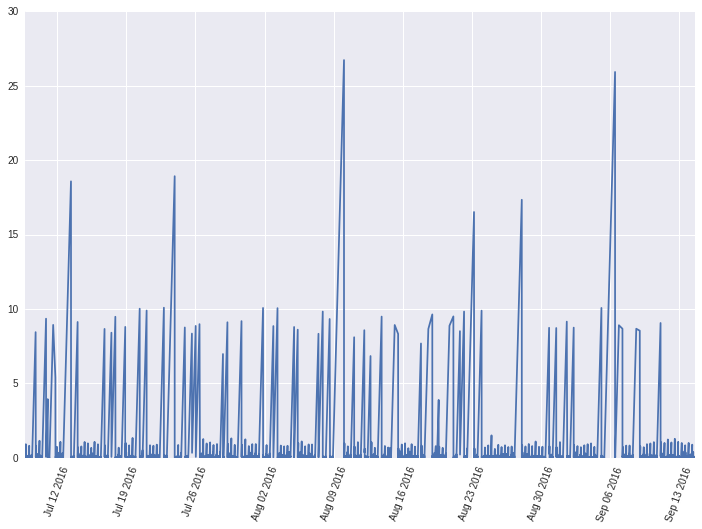

In [16]:
hours = (dtime_deltas['deltas'].astype('timedelta64[s]')/3600)
fig = plt.figure(figsize=(12,8))
plt.xticks(rotation=70)
plt.plot(dtime_deltas['datetime'][1:],(hours[1:]))

In [17]:
deltas_time.sort_values(ascending = False) 

17007   1 days 02:43:46.415000
32030   1 days 01:55:47.474000
7860    0 days 18:55:32.485000
1880    0 days 18:34:47.419000
26191   0 days 17:20:27.079000
23098   0 days 16:31:09.693000
7591    0 days 10:05:18.276000
31723   0 days 10:04:19.492000
13116   0 days 10:04:17.233000
13734   0 days 10:03:28.154000
6193    0 days 10:01:18.081000
6447    0 days 09:53:49.121000
23429   0 days 09:53:26.786000
16372   0 days 09:49:48.915000
22820   0 days 09:49:44.438000
21602   0 days 09:38:18.778000
22506   0 days 09:30:15.689000
18981   0 days 09:29:26.062000
4621    0 days 09:28:45.526000
1100    0 days 09:20:57.470000
16685   0 days 09:19:44.789000
11575   0 days 09:11:11.848000
29295   0 days 09:09:09.755000
2195    0 days 09:07:43.430000
10636   0 days 09:06:34.901000
34442   0 days 09:03:38.220000
8810    0 days 08:58:57.740000
1289    0 days 08:55:57.677000
19788   0 days 08:55:36.058000
32042   0 days 08:54:38.150000
                 ...          
25896   0 days 00:01:02.348000
1969    

## Graphing all intervals less than one hour

37162


(0.1, 1)

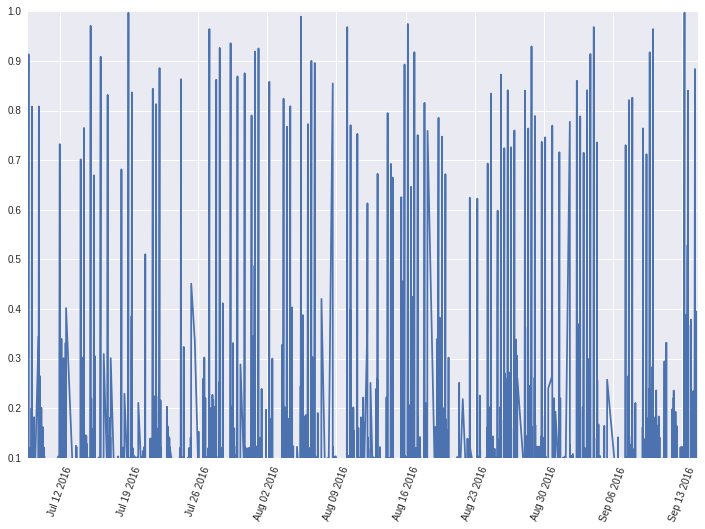

In [18]:
print len(hours[hours < 1])
fig = plt.figure(figsize=(12,8))
ax=fig.add_subplot(111)
plt.xticks(rotation=70)
plt.plot(dtime_deltas['datetime'][1:][hours < 1],(hours[1:][hours < 1]))
plt.ylim(ymin=0.1, ymax=1)

# look more intra day


In [24]:
def plot_24h(ds, example_date = '2016-08-26'):
    ds.sel(datetime=example_date).to_dataframe().plot()  
    print ds_merged_one.to_dataframe().describe()

In [33]:
ds_deltas = xr.Dataset.from_dataframe(dtime_deltas.set_index("datetime"))

In [34]:
ds_deltas

<xarray.Dataset>
Dimensions:   (datetime: 37247)
Coordinates:
  * datetime  (datetime) datetime64[ns] 2016-07-08T18:58:52.413000 ...
Data variables:
    deltas    (datetime) timedelta64[ns] NaT 00:01:17.128000 00:54:49.489000 ...

In [90]:
def plot_small(ds, day="2016-08-26"):    
#     fig = plt.figure(figsize=(12,8))
#     ax=fig.add_subplot(111)
#     plt.xticks(rotation=70)
#     ds.to_dataframe().plot()
#     #plt.ylim(ymin=0.1, ymax=1)
    df_small = ds_deltas.sel(datetime=day).to_dataframe()    
    print len(df_small)
    df_small['mins'] = (df_small['deltas'].astype('timedelta64[s]')/60)
    df_small['mins'].plot()


In [43]:
ds_deltas.datetime

<xarray.DataArray 'datetime' (datetime: 37247)>
array(['2016-07-08T18:58:52.413000000', '2016-07-08T19:00:09.541000000',
       '2016-07-08T19:54:59.030000000', ...,
       '2016-09-14T13:54:23.446000000', '2016-09-14T13:55:42.584000000',
       '2016-09-14T13:58:15.418000000'], dtype='datetime64[ns]')
Coordinates:
  * datetime  (datetime) datetime64[ns] 2016-07-08T18:58:52.413000 ...

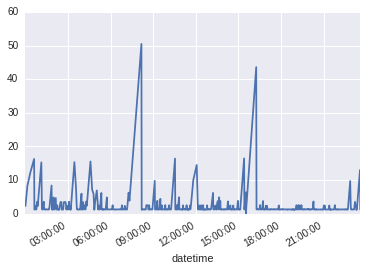

In [66]:
plot_small(ds_deltas, "2016-08-26")

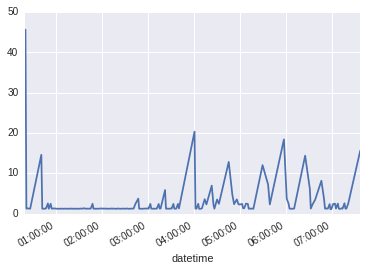

In [69]:
plot_small(ds_deltas, "2016-08-27")

44


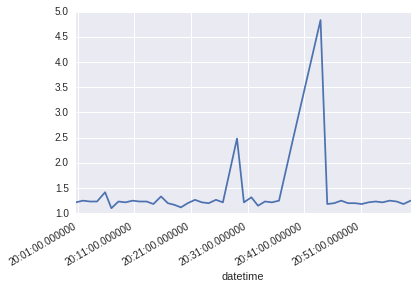

In [97]:
plot_small(ds_deltas, "2016-08-28 20")

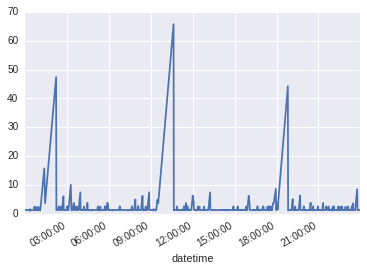

In [71]:
plot_small(ds_deltas, "2016-08-29")

## Autocorrelation across all deltas

In [19]:
import statsmodels.api as sm
from scipy import stats
from statsmodels.graphics.api import qqplot

ImportError: No module named statsmodels.api

In [ ]:
interval_deltas = (dtime_deltas.ix[1:,1].astype('timedelta64[s]')/60)
interval_deltas.head(5)

In [23]:
sm.stats.durbin_watson(interval_deltas)

1.8206549850366802

## Durbin Watson close to 2 - indicating no first-order serial correlation

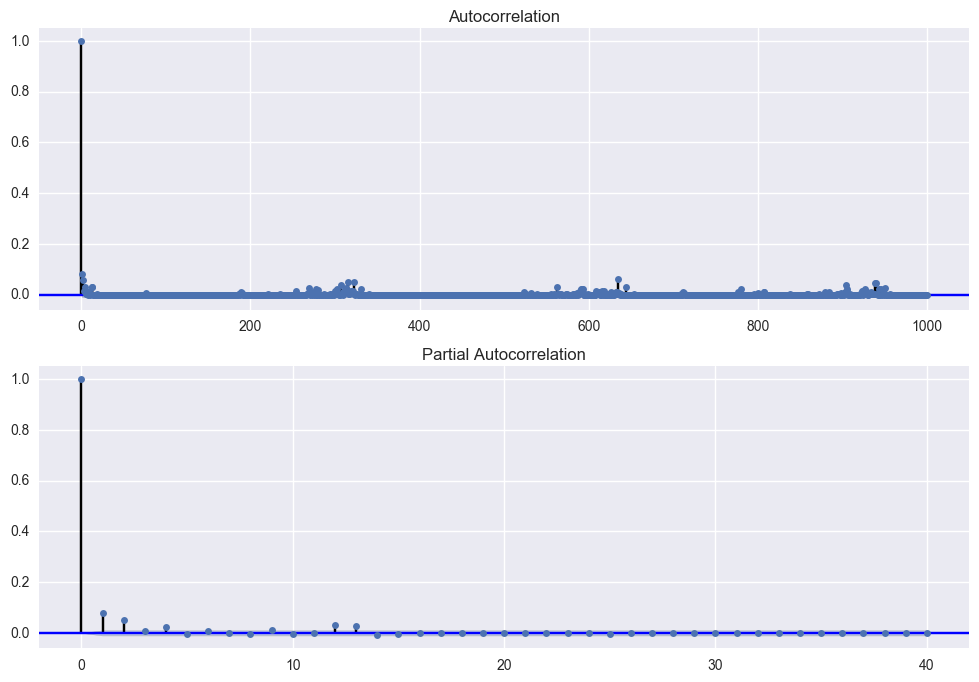

In [24]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(interval_deltas.values.squeeze(),lags = 1000,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(interval_deltas,lags=40,ax=ax2)

## Autocorrelation across deltas < 1 hour

In [31]:
hours = hours[1:]
sm.stats.durbin_watson(hours)

1.8206442990032998

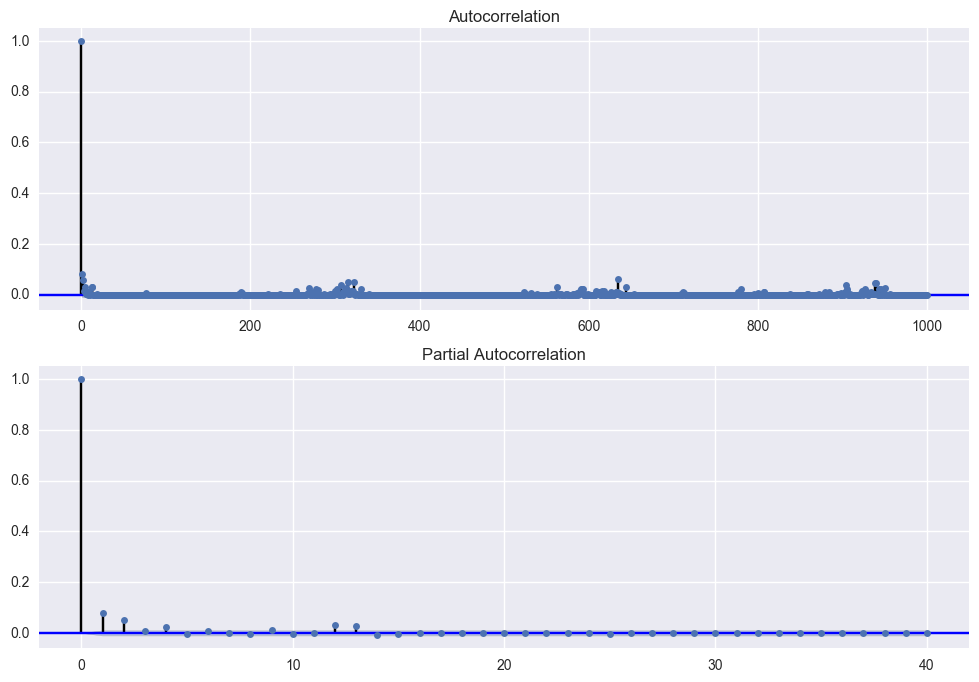

In [32]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(hours.values.squeeze(),lags = 1000,ax = ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(hours,lags=40,ax=ax2)